In [1]:
import os
import glob
import csv
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import AutoARIMA
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

In [4]:
os.getcwd()

'/home/nazim/MAIN4/projetindus2/Code/700-300'

In [5]:
!ls

darts_logs
Projet_bourse_300.ipynb
Projet_climat_300.ipynb
Projet_données_démographiques_300.ipynb
Projet_energie_gaz_eau_electricité_300.ipynb
Projet_maladies_300.ipynb
Sarima_bourse_300.ipynb
Sarima_climat_300.ipynb
Sarima_données_demographiques_300.ipynb
Sarima_energie_gaz_eau_electricité_300.ipynb
Sarima_maladies_300.ipynb
Transformers_bourse.ipynb
Transformers_climat.ipynb
Transformers_données_démographiques.ipynb
Transformers_energie_gaz_eau_electricité.ipynb
Transformers_maladies.ipynb


In [6]:
os.chdir('../../Datasets/Maladies')
os.getcwd()

'/home/nazim/MAIN4/projetindus2/Datasets/Maladies'

In [7]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if(pourcentage < 25):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [28]:
def simul():
    file_name = []
    df = []
    pourcentage = []

    series_scaled_list= []
    val_scaled_list = []
    pred_series_list= []
    error_results = pd.DataFrame(columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
    i = 0
    
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files, delimiter = ';')
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        series = TimeSeries.from_dataframe(df_clean, 'ds', 'y')

        train, val = series[:-300], series[-300:]

        print("the {} dataset has {} data points".format(file_name[i],len(series)))
        
        
        model = AutoARIMA()
        model.fit(train)
        pred_series = model.predict(len(val))
        
        scaler = Scaler()
        train_scaled = scaler.fit_transform(train)
        val_scaled = scaler.transform(val)
        pred_series_scaled = scaler.transform(pred_series)
        series_scaled = scaler.transform(series)
        
        series_scaled_list.append(series_scaled)
        val_scaled_list.append(val_scaled)
        
        pred_series_list.append(pred_series_scaled)
        
        df_new_row_error = pd.DataFrame(data=np.array([[file_name[i],mae(pred_series_scaled, val_scaled), mse(pred_series_scaled, val_scaled), rmse(pred_series_scaled, val_scaled)]]), columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
        error_results = pd.concat([error_results,df_new_row_error], ignore_index=True)
        i = i +1

    return file_name, df, series_scaled_list, val_scaled_list, pred_series_list, error_results

In [29]:
file_name, df, series_scaled_list, val_scaled_list, pred_series_list, error_results = simul()

D-R031
the D-R031 dataset has 1000 data points
D-N02BE1
the D-N02BE1 dataset has 1000 data points
D-N02BE2
the D-N02BE2 dataset has 1000 data points
D-N02BA2
the D-N02BA2 dataset has 1000 data points
D-R032
the D-R032 dataset has 1000 data points
D-N05B1
the D-N05B1 dataset has 1000 data points
D-N02BA1
the D-N02BA1 dataset has 1000 data points
D-N05B2
the D-N05B2 dataset has 1000 data points


In [30]:
error_results.to_csv(r'../../Resultats/Resultats_300/Sarima_results_maladies.csv', index = False)

In [31]:
print(error_results)

  DATA_SET_NAME                  MAE                   MSE  \
0        D-R031   0.1672993445921427  0.053521168428662946   
1      D-N02BE1  0.16295504960576424   0.04044122719057727   
2      D-N02BE2  0.08084564995377687  0.011747278672689982   
3      D-N02BA2  0.12020746812163476  0.024916221704490878   
4        D-R032  0.15332318047398427   0.04876102641988254   
5       D-N05B1  0.11131749499531625  0.022059957645871167   
6      D-N02BA1            0.1279622  0.027278998140851853   
7       D-N05B2  0.06294980625440862  0.006307777820346071   

                  RMSE  
0  0.23134642514779205  
1  0.20110004274136112  
2   0.1083848636696563  
3  0.15784873044941122  
4   0.2208189901704166  
5  0.14852594940235583  
6  0.16516354967380623  
7  0.07942151988186874  


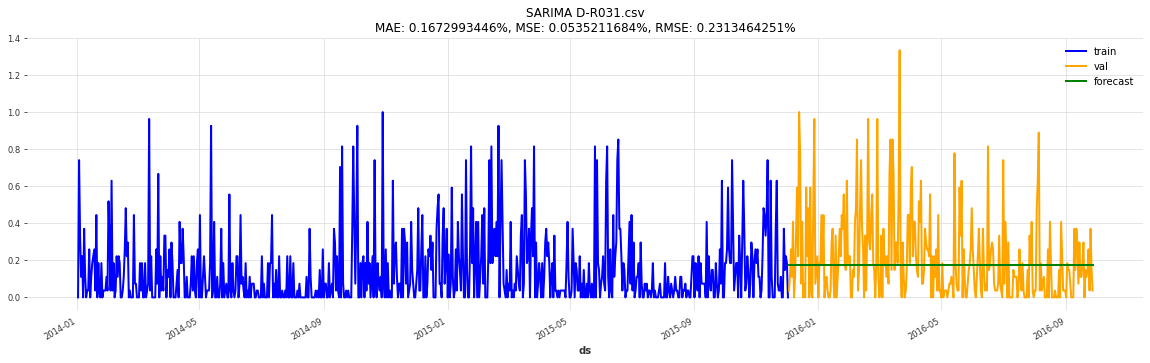

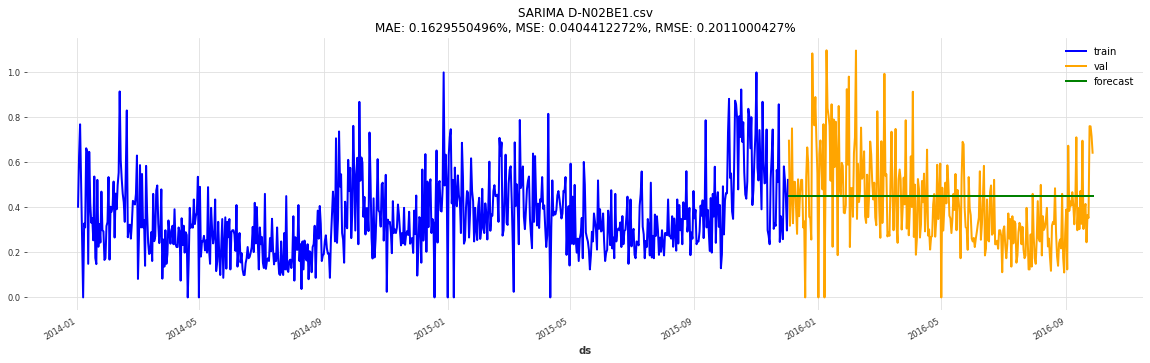

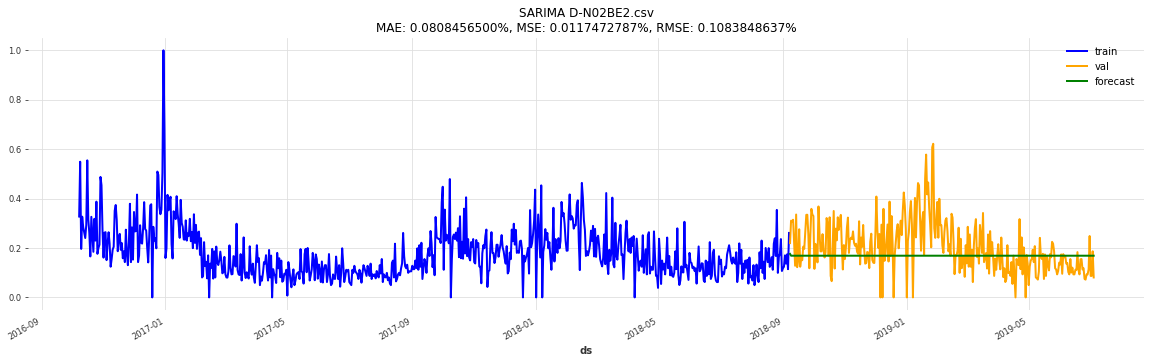

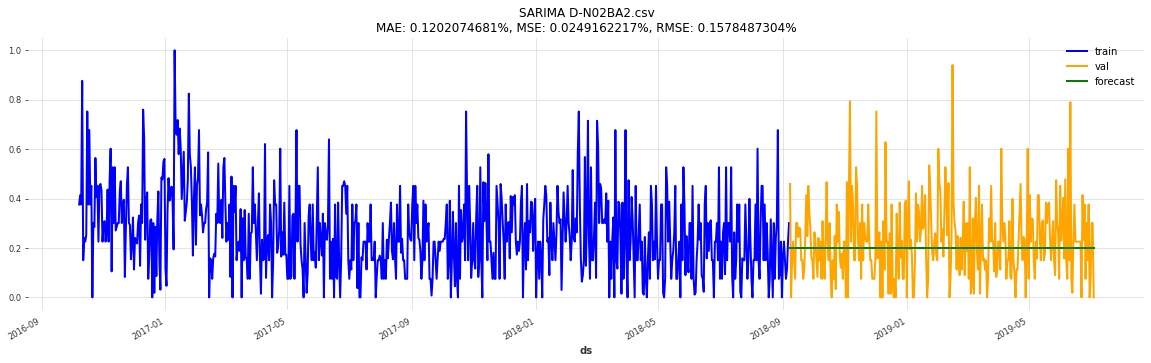

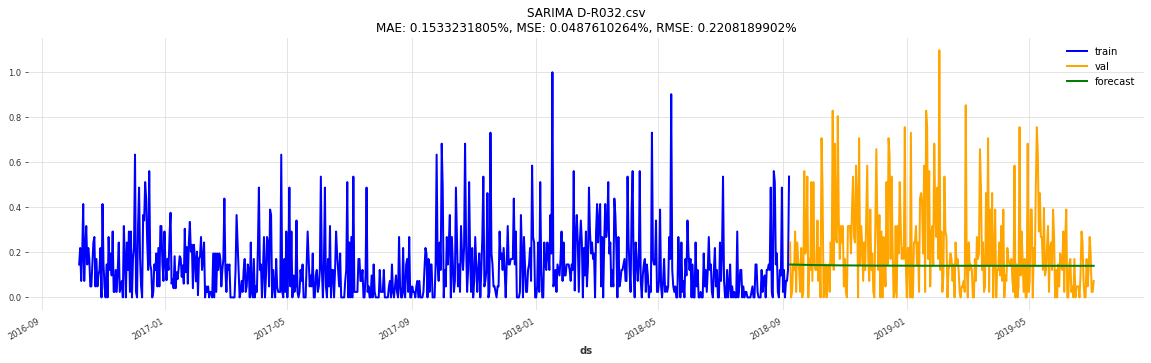

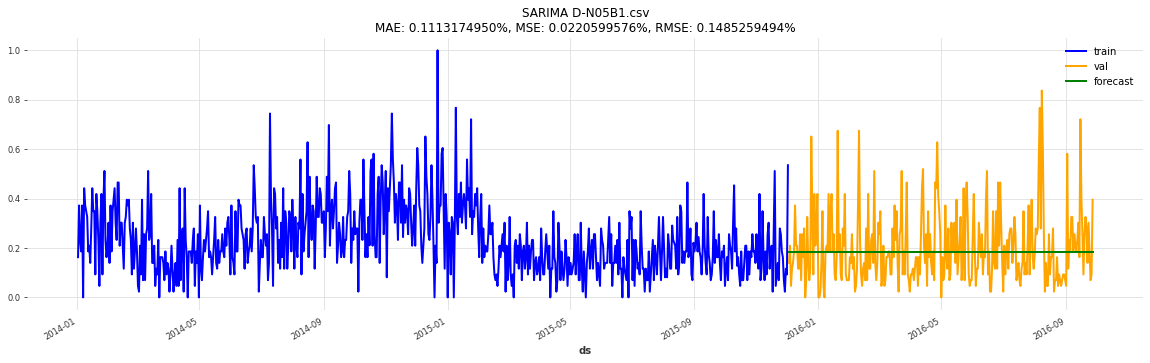

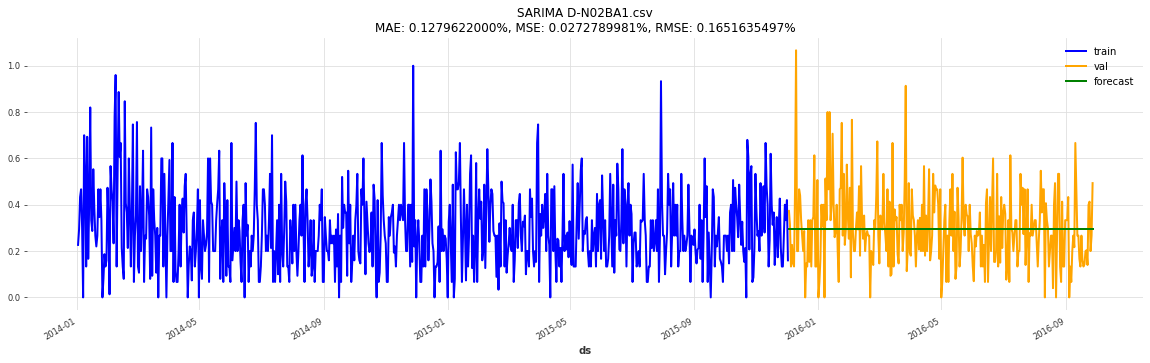

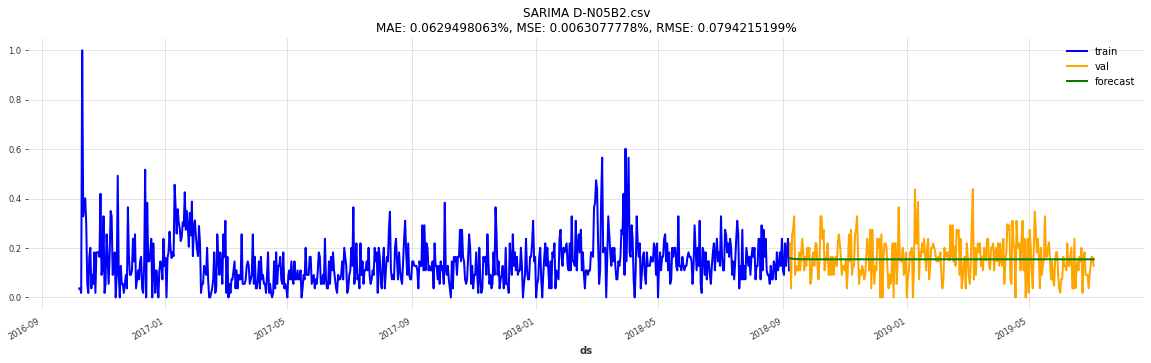

In [32]:
for i in range(len(df)):
    plt.figure(figsize=(20,5))
    train, val = series_scaled_list[i][:-300], series_scaled_list[i][-300:]
    train.plot(color ='blue', label="train")
    val.plot(color ='orange', label="val")
    pred_series_list[i].plot(color ='green',label="forecast")
    plt.title('SARIMA {}.csv\nMAE: {:.10f}%, MSE: {:.10f}%, RMSE: {:.10f}%'.format(file_name[i],mae(pred_series_list[i], val_scaled_list[i]), mse(pred_series_list[i], val_scaled_list[i]), rmse(pred_series_list[i], val_scaled_list[i])))
    plt.legend(loc='best')
    plt.show()